In [2]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172FBWMCS

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [3]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

design_point = C172.TrimParameters()

#complete longitudinal model
P_lss_lon = Control.Continuous.LinearizedSS(ac, design_point; model = :lon);
P_nss_lon = named_ss(P_lss_lon);

x_labels_lon = keys(P_lss_lon.x0) |> collect
y_labels_lon = keys(P_lss_lon.y0) |> collect
u_labels_lon = keys(P_lss_lon.u0) |> collect

x_labels = deleteat!(x_labels_lon, findfirst(isequal(:h), x_labels_lon))
y_labels = deleteat!(y_labels_lon, findfirst(isequal(:h), y_labels_lon))
u_labels = u_labels_lon

#design model
P_lss = Control.Continuous.submodel(P_lss_lon; x = x_labels, u = u_labels, y = y_labels)
P_nss = named_ss(P_lss);

## 1. Regulator

In [4]:
dampreport(P_nss)
controllability(P_nss)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+


| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |


| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |


(iscontrollable = true, ranks = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], sigma_min = [0.004930009049794168, 1.206072642212392, 1.206072642212392, 1.206072642212392, 1.206072642212392, 0.4383425741528633, 0.4336215695880482, 0.4336215695880482, 0.03992908143946816, 0.03992908143946816])

Again, we take the longitudinal dynamics with $h$ removed as baseline.

In [15]:
z_labels = [:EAS, :elevator_cmd]

#before proceeding, ensure consistency in component selection and ordering
#between our design model and MCS avionics implementation for state, control and
#command vectors
@assert tuple(x_labels...) === propertynames(C172FBWMCS.XLon())
@assert tuple(u_labels...) === propertynames(C172FBWMCS.ULon())
@assert tuple(z_labels...) === propertynames(C172FBWMCS.ZLonEASEle())

x_trim = P_lss.x0
u_trim = P_lss.u0
z_trim = P_lss.y0[z_labels]

n_x = length(x_labels)
n_u = length(u_labels)
n_z = length(z_labels)


2

In this case, since we will be using integral control, we need to augment the system before LQR design.

In [21]:
F = P_lss.A
G = P_lss.B
Hx = P_lss.C[z_labels, :]
Hu = P_lss.D[z_labels, :]
display(Hx)
display(Hu)

#define the blocks corresponding to the subset of the command variables for
#which integral compensation is required. in this case, since there is only one,
#we get vectors instead of row matrices, so we need need transposition
Hx_int = Hx[:EAS, :]'
Hu_int = Hu[:EAS, :]'
n_int, _ = size(Hx_int)

F_aug = [F zeros(n_x, n_int); Hx_int zeros(n_int, n_int)]
G_aug = [G; Hu_int]
Hx_aug = [Hx zeros(n_z, n_int)]
Hu_aug = Hu

P_aug = ss(F_aug, G_aug, Hx_aug, Hu_aug)
controllability(F_aug, G_aug)

2×10 ComponentMatrix{Float64} with axes Axis(EAS = 1, elevator_cmd = 2) × Axis(q = 1, θ = 2, v_x = 3, v_z = 4, α_filt = 5, ω_eng = 6, thr_v = 7, thr_p = 8, ele_v = 9, ele_p = 10)
 0.0  0.0  0.952352  0.0224354  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0       0.0        0.0  0.0  0.0  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(EAS = 1, elevator_cmd = 2) × Axis(throttle_cmd = 1, elevator_cmd = 2)
 0.0  0.0
 0.0  1.0

(iscontrollable = true, ranks = [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], sigma_min = [0.004930009049785164, 1.2060726405442117, 1.2060726405442117, 1.2060726405442117, 1.2060726405442117, 0.43833051142545704, 0.43362154390169627, 0.43362154390169627, 0.03989360336224349, 0.03989360336224349, 0.04012233308390007])

In [135]:
@unpack x0, u0 = P_lss
@unpack v_x, v_z = x0
v_norm = norm([v_x, v_z])

#weight matrices
Q = ComponentVector(q = 1, θ = 5, v_x = 1/v_norm, v_z = 1/v_norm, α_filt = 0, ω_eng = 0, thr_v = 0.0, thr_p = 0, ele_v = 0, ele_p = 0, ξ_EAS = 0.01) |> diagm
R = C172FBWMCS.ULon(throttle_cmd = 1, elevator_cmd = 1) |> diagm

#compute gain matrix
C_aug = lqr(P_aug, Q, R)

# quickly construct the closed-loop augmented system to check the resulting
# eigenvalues, we'll do the connections properly later
F_aug_cl = F_aug - G_aug * C_aug
P_aug_cl = ss(F_aug_cl, G_aug, Hx_aug, Hu_aug)

dampreport(P_aug)
dampreport(P_aug_cl)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (r

In [136]:
#extract system state and integrator blocks from the feedback matrix
C_x = C_aug[:, 1:n_x]
C_ξ = C_aug[:, n_x+1:end]
display(C_ξ)

2×1 Matrix{Float64}:
  0.006313453293877529
 -0.007755018241671403

## 2. Throttle + Elevator Feedforward

Now, we determine the feedforward gain matrix for commanding throttle and elevator. Following Stengel section 6.2:

In [137]:
#some useful signal labels
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
u_labels_sum = Symbol.(string.(u_labels) .* "_sum")
u_labels_int_in = Symbol.(string.(u_labels) .* "_int_in")
u_labels_int = Symbol.(string.(u_labels) .* "_int")
u_labels_ξ = Symbol.(string.(u_labels) .* "_ξ")

z_labels_sp = Symbol.(string.(z_labels) .* "_sp")
z_labels_sp1 = Symbol.(string.(z_labels) .* "_sp1")
z_labels_sp2 = Symbol.(string.(z_labels) .* "_sp2")
z_labels_err = Symbol.(string.(z_labels) .* "_err")
z_labels_sum = Symbol.(string.(z_labels) .* "_sum")
z_labels_sp_fwd = Symbol.(string.(z_labels) .* "_sp_fwd")
z_labels_sp_sum = Symbol.(string.(z_labels) .* "_sp_sum")

A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]

C_fbk = C_x
C_fbk_ss = named_ss(ss(C_fbk), u = x_labels, y = u_labels_fbk)

C_fwd = B_22 + C_x * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp_fwd, y = u_labels_fwd)

#the integral gain matrix is constructed by padding C_ξ with zeros in those
#columns corresponding to command variables without integral compensation
C_int = ComponentMatrix(zeros(n_u, n_z), Axis(u_labels), Axis(z_labels))
C_int[:, :EAS] .= C_ξ
C_int_ss = named_ss(ss(C_int), u = z_labels_err, y = u_labels_int_in)

int_ss = named_ss(ss(tf(1, [1,0])) .* I(2),
                    x = u_labels_ξ,
                    u = u_labels_int_in,
                    y = u_labels_int);

EAS_err_sum = sumblock("EAS_err = EAS_sum - EAS_sp_sum")
elevator_cmd_err_sum = sumblock("elevator_cmd_err = elevator_cmd_sum - elevator_cmd_sp_sum")

throttle_cmd_sum = sumblock("throttle_cmd_sum = throttle_cmd_fwd - throttle_cmd_fbk - throttle_cmd_int")
elevator_cmd_sum = sumblock("elevator_cmd_sum = elevator_cmd_fwd - elevator_cmd_fbk - elevator_cmd_int")

EAS_sp_splitter = splitter(:EAS_sp, 2)
elevator_cmd_sp_splitter = splitter(:elevator_cmd_sp, 2)

connections = vcat(
    Pair.(x_labels, x_labels),
    Pair.(z_labels, z_labels_sum),
    Pair.(z_labels_sp1, z_labels_sp_sum),
    Pair.(z_labels_sp2, z_labels_sp_fwd),
    Pair.(z_labels_err, z_labels_err),
    Pair.(u_labels_sum, u_labels),
    Pair.(u_labels_fwd, u_labels_fwd),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_int, u_labels_int),
    Pair.(u_labels_int_in, u_labels_int_in),
    )

P_nss_EAS_ele = connect([P_nss, int_ss, C_fwd_ss, C_fbk_ss, C_int_ss,
                    EAS_err_sum, elevator_cmd_err_sum,
                    throttle_cmd_sum, elevator_cmd_sum,
                    EAS_sp_splitter, elevator_cmd_sp_splitter], connections;
                    w1 = z_labels_sp, z1 = vcat(y_labels))
# display(C_fbk_ss)
# display(C_fwd_ss)
# display(C_int_ss)
# display(int_ss)
# display(connections)

dampreport(P_nss_EAS_ele)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -1.37e-16          |  1            |  1.37e-16     |  2.17e-17     |  7.32e+15     |
| -0.0677            |  1            |  0.0677       |  0.0108       |  14.8         |
| -0.486  ±  0.344im |  0.817        |  0.596        |  0.0948       |  2.06         |
| -10.5   ±   4.21im |  0.928        |  11.3         |  1.81         |  0.0949       |
| -11.7              |  1            |  11.7         |  1.86         |  0.0857       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.4   ±   26.7im |  0.566        |  32.4         |  5.16         |  0.0545       |
| -47.1              |  1            |  47.1         |  7.5          |  0.0212       |


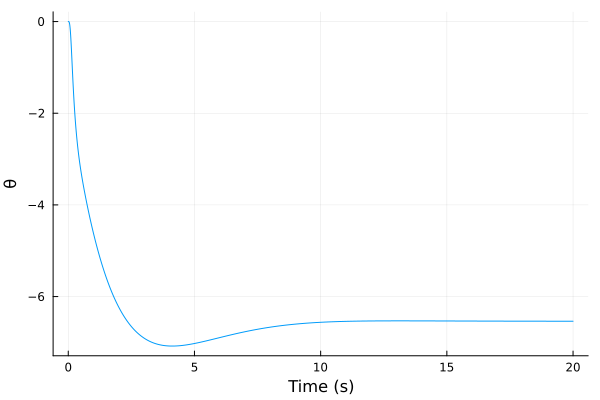

In [139]:
e2e_fbk_fwd = P_nss_EAS_ele[:θ, :elevator_cmd_sp]
# e2e_fbk_fwd = P_nss_EAS_ele[:EAS, :elevator_cmd_sp]
# e2e_fbk_fwd = P_nss_EAS_ele[:elevator_cmd, :EAS_sp]
# e2e_fbk_fwd = P_nss_EAS_ele[:elevator_cmd, :elevator_cmd_sp]
# e2e_fbk_fwd = P_nss_EAS_ele[:throttle_cmd, :EAS_sp]
# e2e_fbk_fwd = P_nss_EAS_ele[:EAS, :EAS_sp]
step(e2e_fbk_fwd, 20) |> plot